In [27]:
from statsmodels.stats.power import TTestIndPower

import numpy as np
import pandas as pd

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Randomized Controlled Trials (aka. A/B tests)

## Ресурсы
**Medium:**

[Medium: A Practical Guide To A/B Tests in Python](https://towardsdatascience.com/a-practical-guide-to-a-b-tests-in-python-66666f5c3b02)

[Medium: Implementing A/B Tests in Python](https://bondicrypto.medium.com/implementing-a-b-tests-in-python-514e9eb5b3a1)

**Академия Яндекса:**

[Яндекс: Как провести A/B-тестирование: 6 простых шагов](https://academy.yandex.ru/posts/kak-provesti-a-b-testirovanie-6-prostykh-shagov)

## Описание ситуации

Допустим мы занимаемся разработкой приложения TikTok. Мы разрабатываем новую функцию по фильтрации животных и хотим оценить эффект от ее внедрения. Нас интересуют две основные метрики:

1. Как фильтры влияют на активность пользователей (engagement - время проведенное в приложении)?
2. Как фильтры влияют на удержание пользователей (retention - количество пользователей, которые возвращаются в наше приложение спустя X временных периодов)?

## Подготовка теста

### В чем состоит цель тестирования?



### Как измерить результат? 
Определить набор метрик изменение которых будет отслеживаться в процессе теста.

### Какой размер выборки будет достаточным для тестирования?
Обычная практика завершать тест после получения статистически значимых результатов (небольшое p-value). Однако подобный p-hacking - плохая практика, которая может привести к предвзятым ложно-положительным результатам.

Вместо этого, лучше определить минимальный размер выборки используя три параметра:

1. **The significance Level - Уровень значимости (α)** - вероятность отвергнуть правдивую нуливую гипотезу.
2. **Statistical Power - Статистическая мощность** - вероятность отклонения основной гипотезы в случае, когда конкурирующая гипотеза верна
Power = 1 — Type II Error
3. **The Minimum Detectable Effect, MDE - Минимально обнаруживаемый эффект** - минимальное различие между двумя группами, измеренное в количестве стандартных отклонений, при котором внесение изменений в продукт будет целесообразно.

Зависимоть между изменением этих параметров и размером выборки:

Уменьшение уровня значимости → Увеличение выборки
Увеличение статистической мощьности → Увеличение выборки
Уменьшение MDE → Увеличение выборки


Обычно ставится уровень значимости 5% (α=0.05) и стандартное отклонение в 80%. Тогда размер выборки вычисляется по формуле:
![plot](data/img/sample_size.png)

где

σ² - дисперсия выборки

𝛿 - разница между двумя группами (в процентах)

Чтобы измерить дисперсию выборки, можно провести A/A-тест. Тоесть провести тест, где в обе группы внесено изменение. 

In [6]:
# parameters for power analysis 
# effect_size has to be positive
effect = 0.1
alpha = 0.05
power = 0.8

# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(
    effect_size=effect, 
    power = power,
    nobs1= None, 
    ratio = 1.0, 
    alpha = alpha)
print('Sample Size: %.3f' % round(result))

Sample Size: 1571.000


## Генерация данных для теста

**Data Generation Process (DGP) - процесс генерации данных** - создание переменных с известным распределением. По ним мы можем отследить влияние, котороу вносит изменение. Сможем оценить эффективность A/B тестов и проверить, в какой степени они приводят к объективным результатам.

### Генерация переменных

#### variable 1: user id

In [23]:
user_id_control = list(range(1,1601)) # 1600 control
user_id_treatment = list(range(1601,3350)) # 1749 treated

#### variable 2: version

In [24]:
control_status = ['control']*1600
treatment_status = ['treatment']*1749

#### variable 3: minutes of plays

In [25]:
# for control group
np.random.seed(123)

μ_1 = 30
σ_squared_1 = 10
minutes_control = np.random.normal(loc = μ_1, scale = σ_squared_1, size = 1600)

# for treatment group, which increases the user engagement by 
# according to the formula (μ_1 — μ_2)/σ_squared = 0.1, we obtain μ_2 = 31
np.random.seed(123)

μ_2 = 31
σ_squared_2 = 10
minutes_treat = np.random.normal(loc = μ_2, scale = σ_squared_2, size = 1749)

#### variable 4: user engagement after 1 day, metric_1

По логике нашей симуляции, контрольная группа (control group) содержит 30% активных (True) и 70% неактивных (False) пользователей после 1 дня. 

В то время как экспериментальная группа (treatment group) содержит 35% активных и 65% неактивных пользоватлей, соответственно.

In [26]:
Active_status = [True,False]

# control 
day_1_control = np.random.choice(Active_status, 1600, p=[0.3,0.7])

# treatment
day_1_treatment = np.random.choice(Active_status, 1749, p=[0.35,0.65])

#### variable 5: user engagement after 7 day metric_1

По логике симуляции, спустя 7 дней,

Контрольная группа содержит 35% активных пользователей.

В то время как экспериментальная группа содержит 25% активных пользователей

In [21]:
# control 
day_7_control = np.random.choice(Active_status, 1600, p=[0.35,0.65])
# treatment
day_7_treatment = np.random.choice(Active_status, 1749, p=[0.25,0.75])

# По задумке, изменение обеспечивает улучшение по метрике удержания в краткосрочном периоде. Но спустя 1 неделю этот эффект сходит на нет.
# И контрольная группа обеспечивает лучшие результаты.

In [34]:
# control data

raw_control = {'user_id':user_id_control,
                 'version':control_status,
               'minutes_play':minutes_control,
               'day_1_active':day_1_control,
               'day_7_active':day_1_control
                }

control_group = pd.DataFrame(data = raw_control)
control_group.head()

,user_id,version,minutes_play,day_1_active,day_7_active
0,1,control,19.143694,False,False
1,2,control,39.973454,True,True
2,3,control,32.829785,False,False
3,4,control,14.937053,False,False
4,5,control,24.213997,False,False


In [33]:
# treatment data 
raw_treatment = {'user_id':user_id_treatment,
                 'version':treatment_status,
               'minutes_play':minutes_treat,
               'day_1_active':day_1_treatment,
               'day_7_active':day_7_treatment
                }

treatment_group = pd.DataFrame(data = raw_treatment)
treatment_group.head()

,user_id,version,minutes_play,day_1_active,day_7_active
0,1601,treatment,20.143694,False,True
1,1602,treatment,40.973454,True,False
2,1603,treatment,33.829785,True,False
3,1604,treatment,15.937053,False,False
4,1605,treatment,25.213997,False,False


In [32]:
# combine these two datasets
two_datasets = pd.concat([control_group, treatment_group])

# randomize the orders using df.sample(frac=1)
# The frac keyword argument: specifies the fraction of rows to return in the random sample
# so frac=1 means return all rows (in random order).
final_data = two_datasets.sample(frac=1)
final_data

,user_id,version,minutes_play,day_1_active,day_7_active
1164,2765,treatment,20.477210,False,True
694,695,control,14.694871,True,True
1497,3098,treatment,30.579927,False,True
1187,1188,control,23.955633,False,False
1595,1596,control,27.154466,False,False
...,...,...,...,...,...
925,926,control,43.382205,False,False
1569,1570,control,13.695035,False,False
1556,1557,control,31.314893,False,False
1116,2717,treatment,17.775269,True,False


## Проведение теста

In [35]:
# calculate the number of users in each version
final_data.groupby('version')['user_id'].count()

version
control      1600
treatment    1749
Name: user_id, dtype: int64

In [46]:
sum([1600,1749])

3349

In [47]:
sum([1675,1675])

3350

In [44]:
from scipy.stats import chisquare 

chisquare([1600,1749],f_exp = [1675,1675])

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.00029859659599880563

Text(0, 0.5, 'User Count')

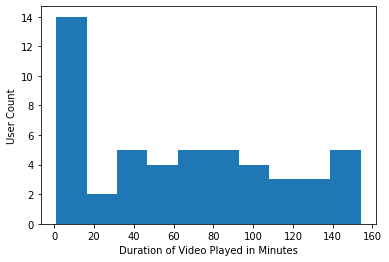

In [49]:
%matplotlib inline

final_data['minutes_play_integers'] = round(final_data['minutes_play'])
plot_df = final_data.groupby('minutes_play_integers')['user_id'].count()

# Plot the distribution of players that played 0 to 50 minutes
ax = plot_df.head(n=50).plot(x="minutes_play_integers", y="user_id", kind="hist")
ax.set_xlabel("Duration of Video Played in Minutes")
ax.set_ylabel("User Count")

### Metric 1: 1-day retention by AB-Group

In [50]:
# 1-day retention
final_data['day_1_active'].mean()

0.32218572708271126

In [51]:
# 1-day retention by group
final_data.groupby('version')['day_1_active'].mean()

version
control      0.293125
treatment    0.348771
Name: day_1_active, dtype: float64

#### Вопросы:
1. У измененной группы фиксируется более высокий уровень удержания (0.35) по сравнению с контрольной группой (0.29). Эта разница значима?
2. До какой степени мы можем доверять результату?
3. What is the variability of the difference?
4. Другими словами, как часто мы получаем экстремальные значения? РЕШЕНИЕ: Bootstrap (resampling, replication) and check for the variability

<AxesSubplot:ylabel='Density'>

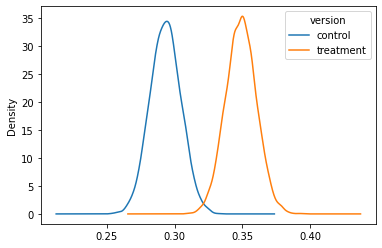

In [52]:
# solution: bootstrap
boot_means = []

# run the simulation for 10k times 
for i in range(10000):
    #frac=1 means randomize the order of all rows 
    boot_sample = final_data.sample(frac=1,replace=True).groupby('version')['day_1_active'].mean()
    boot_means.append(boot_sample)

# a Pandas DataFrame
boot_means = pd.DataFrame(boot_means)

# kernel density estimate
boot_means.plot(kind = 'kde');

In [53]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['diff'] = (boot_means['treatment'] - boot_means['control'])/boot_means['control']*100
boot_means['diff']

day_1_active    26.592389
day_1_active    19.140264
day_1_active    26.364939
day_1_active    25.685590
day_1_active    20.500721
                  ...    
day_1_active    21.139168
day_1_active    14.441930
day_1_active    22.023041
day_1_active    16.706841
day_1_active    17.797644
Name: diff, Length: 10000, dtype: float64

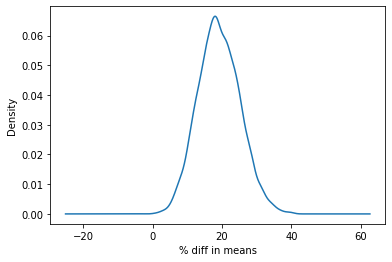

In [54]:
# plot the bootstrap sample difference 
ax = boot_means['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means");

In [55]:
boot_means[boot_means['diff'] > 0]

version,control,treatment,diff
day_1_active,0.288278,0.364937,26.592389
day_1_active,0.292470,0.348450,19.140264
day_1_active,0.286718,0.362311,26.364939
day_1_active,0.286429,0.360000,25.685590
day_1_active,0.284635,0.342987,20.500721
...,...,...,...
day_1_active,0.297331,0.360184,21.139168
day_1_active,0.291929,0.334090,14.441930
day_1_active,0.292787,0.357268,22.023041
day_1_active,0.297264,0.346927,16.706841


In [56]:
# p value 
p = (boot_means['diff'] >0).sum()/len(boot_means)
p

0.9999

Conclusion 1: treatment has a better performance than the control on 1-day user retention 99.96% of the time.
Вывод 1: Изменная группа показывает лучшие результаты, чем контрольная группа по метрике удержания спустя 1 день, в 99.96% случаев.

### Metric 7: 7-day retention by AB-Group

In [57]:
boot_7d = []

for i in range(10000):
    #set frac=1 --> sample all rows
    boot_mean = final_data.sample(frac=1,replace=True).groupby('version')['day_7_active'].mean() 
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['treatment'] - boot_7d['control'])/boot_7d['control'] *100

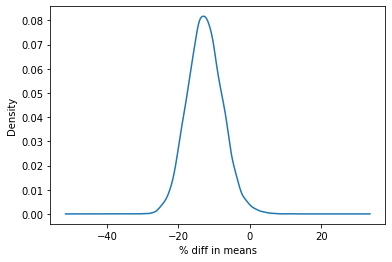

In [58]:
# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means");

In [59]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
p = (boot_7d['diff']>0).sum()/len(boot_7d)

1-p

0.991

Conclusion 2: control has a better performance than the treatment on 7-day user retention 99.89% of the time.
Вывод 2: Контрольная группа демонстрирует лучшие результаты чем экспериментальная группа по метрике удержания, спустя неделю, в 99.89% случаев.

## Бизнес выводы

В первое время, после внедрения фильтров клиенты были заинтригованы, и активность повысилась. Однако, этот эффект был временным и не увеличил активность клиентов на постоянной основе. 

## Лучшие практики

SRM is a real concern. We apply a chi-square test to formally test for the SRM. If the p-value is smaller than the threshold (α = 0.001), the randomization process does not work as expected.


An SRM introduces selection bias that invalidates any test results.

Three fundamental statistical concepts to master: SRM, chi-square test, and bootstrap.
Три фундоментальные статистические концепции, которыми нужно овладеть: SRM, Хи-квадрат тест + t-Стьюдента, и bootstrap

Compare short-term and long-term metrics to evaluate the novelty effect.